In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
?df.VectorElement

In [23]:
element.family()

'Lagrange'

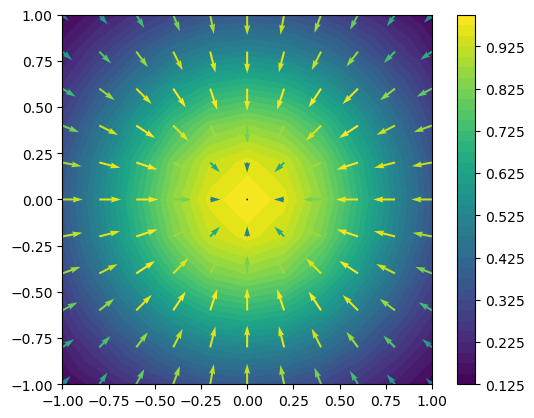

In [38]:
import matplotlib.pyplot as plt

import dolfin as df
import ufl
from dolfin import inner, grad

domain = df.RectangleMesh(df.Point(-1, -1), df.Point(1, 1), 10, 10)
element = df.FiniteElement(family="CG", cell=ufl.Cell("triangle"), degree=1)
V = df.FunctionSpace(domain, element)
W = df.FunctionSpace(
    domain, 
    df.VectorElement(
        element.family(), element.cell(), element.degree(), dim=domain.geometric_dimension()
    ))

dt = 0.1
T = 10.0
time = TimeKeeper(dt, T)

p_expr = df.Expression("(1 - t/T) * exp(-(x[0]*x[0] + x[1]*x[1]))", degree=1, domain=domain, t=time, T=T)
vel_expr = grad(p_expr)
p = df.project(p_expr, V)
vel = df.project(vel_expr, W)

c = df.plot(p)
df.plot(vel)
plt.colorbar(c)

In [40]:
from dolfin import inner, grad

In [41]:
from pantarei.timekeeper import TimeKeeper

In [28]:
def abstract_convection_diffusion_form():
    def form(V, coefficients, boundaries):
        u = df.TrialFunction(V)
        w = df.TestFunction(V)
        D = coefficients["D"]
        v = coefficients["velocity"]
        u0 = coefficients["initial_condition"]
        assert isinstance(u0, df.Function), "project initial_condition onto u0 first."
        dx = Measure('dx', domain=V.mesh())
        F = ((u - u0)*w + dt * inner(-D * grad(u) + u * v, grad(w))) * dx
        return F
    return form

In [29]:
diffusion_form = abstract_convection_diffusion_form()

In [30]:
v_scale = 0.1
coefficients = {
    "D": 0.4,
    "velocity": vel,
    "initial_condition": p
}

In [ ]:
xdmf = XDMFFile("conv-diff")

In [19]:
dt = 0.1
T = 10.0
time = TimeKeeper(dt, T)

In [18]:
time.reset()

V = df.FunctionSpace(domain, element)
dirichlet_bcs = process_dirichlet(V, domain, boundaries)
storage = TimeSeriesStorage("w", storage_path, mesh=domain, V=V)
computer = set_optional(computer, BaseComputer, {})
updater = set_optional(updater, ProblemUpdater)

# Prepare initial conditions
u0 = df.project(initial_condition, V, bcs=dirichlet_bcs)
# TODO: Allow different name for coefficient.
if "u0" in coefficients:
    raise ValueError(f"Coefficient list already has initial condition entry.")
else:
    coefficients["u0"] = u0
u = Function(V, name=name)
u.assign(u0)

# TODO: 
# 1) Switch form to a closure/callable.
# 2) Change "process" to take in the form, rather than test/trialfunctions.
F = form.create_fem_form(V, coefficients, boundaries)
a: Form = lhs(F) #  type: ignore (lhs/rhs allow too many return-types.)
l: Form = rhs(F) #  type: ignore (lhs/rhs allow too many return-types.

A = assemble(a)

computer.compute(time, u)
updater.update(u, time, coefficients)
storage.write(u, float(time))
for idx, ti in enumerate(time):
    b = assemble(l)
    solver.solve(u, A, b, dirichlet_bcs)
    computer.compute(ti, u)
    updater.update(u, ti, coefficients)
    storage.write(u, float(ti))
    coefficients["u0"].assign(u)

storage.close()
return computer

NameError: name 'time' is not defined

Want to create a method for storing:
1. A mesh
2. For several functions sharing this mesh:
    1. A finite-element signature.
    2. If it is time-dependent, store the timestamps for the data.
    3. The data at each timestamp for the data
    
    
As a special case, consider the above system with 
- A fixed mesh
- A time-dependent function u representing concentration.
- A stationary state p.
- A stationaru vector-field V.

The idea for investigating now will be to define all of these functions, and see if I'm able to write all of them to an xdmf-file.

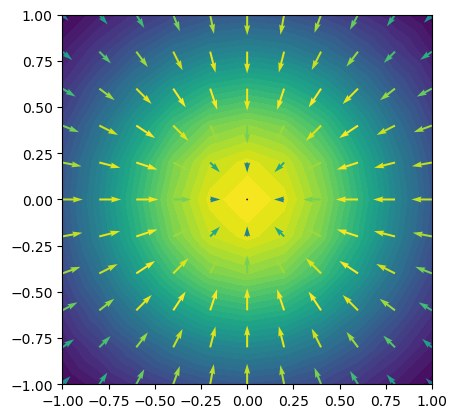

In [69]:
import dolfin as df
import ufl
from dolfin import inner, grad

domain = df.RectangleMesh(df.Point(-1, -1), df.Point(1, 1), 10, 10)
element = df.FiniteElement(family="CG", cell=ufl.Cell("triangle"), degree=1)
V = df.FunctionSpace(domain, element)
W = df.FunctionSpace(
    domain, 
    df.VectorElement(
        element.family(), element.cell(), element.degree(), dim=domain.geometric_dimension()
    ))

p_expr = df.Expression("exp(-(x[0]*x[0] + x[1]*x[1]))", degree=1, domain=domain)
vel_expr = grad(p_expr)

p = df.project(p_expr, V)
vel = df.project(vel_expr, W)
p.rename("pressure", "")
vel.rename("velocity", "")

df.plot(p)
df.plot(vel)

In [76]:
xdmf = df.XDMFFile(domain.mpi_comm(), "testfile.xdmf")
xdmf.parameters["rewrite_function_mesh"] = False
xdmf.parameters["functions_share_mesh"] = True
xdmf.write(domain)
xdmf.write_checkpoint(p, "pressure", 0.0)
xdmf.write_checkpoint(p, "pressure", 0.1, append=True)
xdmf.write_checkpoint(vel, "velocity", 0.0, append=True)

xdmf.close()

In [35]:
u0 = p.copy(True)